In [1]:
%matplotlib widget

import scipy.stats as st
import scipy.signal as ss
from tqdm import tqdm
import numpy as np
import lightkurve as lk 
import pandas as pd 
from numpy.fft import fft, ifft
import astropy.units as au
import astropy.constants as ac
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from celerite2.numpy import GaussianProcess
from scipy.interpolate import PchipInterpolator
from celerite2 import terms
np.random.seed(427)

import warnings
warnings.filterwarnings('ignore')

/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/neisner/.lightkurve/cache. Please move all the files in the legacy directory /Users/neisner/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [17]:
# plotting variables
figsize = (9,5)
#frequency_xlim = [0., 70.]
fontsize = 15

In [3]:
def sort_lists(list1, list2):
    '''
    Sort according to list 1
    '''
    # Use zip to combine the two lists element-wise
    combined_lists = zip(list1, list2)

    # Sort the combined lists based on the elements of list1
    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0])

    # Unpack the sorted lists
    sorted_list1, sorted_list2 = zip(*sorted_combined_lists)

    return list(sorted_list1), list(sorted_list2)


In [9]:
def identify_gaps(times, small_gap_size):
    
    dts = np.diff(times)
    
    big = small_gap_size * np.nanmedian(dts)
    
    small = 1.5 * np.nanmedian(dts)
    
    big_gap_idx = np.where(dts > big)[0]

    small_gap_indx = np.where((dts > small) * (dts < big))[0]
    
    gap_start_times = list(times[big_gap_idx])
    gap_end_times =   list(times[big_gap_idx + 1])
    
    chunk_start_times = np.array([np.nanmin(times)] + gap_end_times)
    chunk_end_times = np.array(gap_start_times + [np.nanmax(times)])

    small_gap_start_times = list(times[small_gap_indx])
    small_gap_end_times =   list(times[small_gap_indx + 1])
    
    print ("- - - - - ")
    print ("number of big gaps: {}".format(len(gap_start_times)))
    print ("number of small gaps: {}".format(len(small_gap_start_times)))
    print ("- - - - - ")
    print ()
    return gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, np.nanmedian(dts)

# make a minimal frequency grid
def get_fgrid(times, frequency_oversampling, frequency_xlim):

    deltaf = 1. /(np.max(times) - np.min(times)) / frequency_oversampling

    # set the max frequency to the rough equivalent of Nyquist
    maxf = deltaf * len(times) / 2.

    # or set the max frequency by hand
    maxf = frequency_xlim[-1]

    # run the LS periodogram
    return np.arange(deltaf, maxf, deltaf)


In [10]:
def interpolate_small_gaps(time_array, flux_array, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False):

    in_gap_time_list = []
    in_gap_flux_list = []

    # make sure that the lists are sorted in time - otherwise we can't interpolate - for some reason this is not always the case
    time_array, flux_array = sort_lists(time_array, flux_array) # sort according to list 1

    for start,end in tqdm(zip(small_gap_start_times, small_gap_end_times)):

        # create a cut out around the small gap - this will be used to interpolate the data and to then fill in the gap with the interpolated data
        
        gap_window = (time_array > (start - interpolate_window)) * (time_array < (end + interpolate_window))
        
        # Create a PchipInterpolator object
        pchip_interpolator = PchipInterpolator(time_array, flux_array, extrapolate =False)
        
        # create grid to interpolate onto - this it the missing data points
        times_in_gap = np.arange(start + cadence, end, cadence)
        
        # interpolate the data
        flux_in_gap = pchip_interpolator(times_in_gap)
        
        in_gap_time_list.append(times_in_gap)
        in_gap_flux_list.append(flux_in_gap)
        
    # add the original data
    in_gap_time_list.append(time_array)
    in_gap_flux_list.append(flux_array)

    times_interpolated_small = np.hstack(in_gap_time_list)
    fluxes_interpolated_small = np.hstack(in_gap_flux_list)

    times_interpolated_small, fluxes_interpolated_small = sort_lists(times_interpolated_small, fluxes_interpolated_small) # sort according to list 1

    if plot == True:
        # check that the small gaps have gone and that the big gaps are still there
        fig, ax = plt.subplots(figsize = figsize)

        plt.scatter(times_interpolated_small, np.zeros_like(fluxes_interpolated_small), s = 10)

        for s,e in zip(chunk_start_times, chunk_end_times):
            ax.axvspan(s, e, alpha=.05, color='navy')

        plt.show()

    return times_interpolated_small, fluxes_interpolated_small


In [11]:
# define the minimum chunk size that will be used for Welch

def which_chunks(times, fluxes, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False):
    
    '''
    Function to determine which of the large chunks should be used for Welch.
    '''
    
    # first, make arrays of the flux, time for each chunk of data that is larger than the minimum chunk size
    chunks_times = []
    chunks_fluxes = []
    used_chunk_sizes = []

    if plot_chunks == True:
        fig, ax = plt.subplots(figsize = figsize)
        plt.scatter(times, np.zeros_like(fluxes), s = 10)

    for start_chunk,end_chunk in zip(chunk_start_times, chunk_end_times):
        
        chunk_size = end_chunk - start_chunk # chunk size in days
        
        if (chunk_size) > min_welch_chunk: # if yes, then we can use it
            in_chunk = (times > start_chunk) * (times < end_chunk)
            
            chunks_times.append(np.array(times)[in_chunk])
            chunks_fluxes.append(np.array(fluxes)[in_chunk])
            used_chunk_sizes.append(chunk_size)

            if plot_chunks:
                ax.axvspan(start_chunk, end_chunk, alpha=.05, color='maroon')
            
            if extra_info:
                print ("used chunk: {} days".format(chunk_size))
        else: 
            if extra_info:
                print ("chunk too small with length: {} days   (not used)".format(chunk_size))
    
    if plot_chunks:
        plt.show()
    
    print ()
    print ("- - - - - ")
    print ("number of discarded chunks: {}".format(len(chunk_start_times) - len(chunks_times)))
    print ("number of used chunks: {}".format(len(chunks_times)))
    print ("- - - - - ")
    
    return chunks_times, chunks_fluxes, used_chunk_sizes


def welch(times, fluxes, chunks_times, chunks_fluxes, segment_size, fgrid, plot_log = [True, True], extra_info = False, plot_chunks = False, plot_results = True, plot_welch_comparison = False, injected_omegas = None, known_frequencies = None):
    
    '''
    function to run Welch on the individual chunks of data and median combine it together
    times: time array
    fluxes: flux array
    chunk_start_times: start times of the chunks
    chunk_end_times: end times of the chunks
    min_welch_chunk: minimum chunk size in days
    segment_size: size of the segments in days
    frgid: frequency grid (only needed if the plot_welch_comparison is True - needed for the LS comparison)
    plot_chunks: if True plot the chunks of data that are used for Welch
    plot_results: if True plot the results of the Welch
    plot_welch_comparison: if True plot the Welch results and compare to the LS
    injected_omegas: if not None, plot the injected frequencies on the Welch plot
    '''


    # now run welch on each chunk 
    
    # we now have the chunks of data (where the small gaps have been interpolated) that we will use for Welch
    if plot_results:
        fig, ax = plt.subplots(figsize = figsize)

    fs_welch_list = []
    psd_welch_list = []

    sampling_frequency = 1/(np.nanmedian(np.diff(times))) # for 2 minute cadence data this is 720 d-1
    nperseg = int(segment_size * sampling_frequency)
    
    for time, flux in zip(chunks_times, chunks_fluxes):

        fs, psd = ss.welch(flux, fs=sampling_frequency, nperseg = nperseg, average = 'median')
        
        fs_welch_list.append(fs)
        psd_welch_list.append(psd)

        if plot_results:
            plt.plot(fs, psd, alpha = 0.4)

    fs_welch_median = np.median(np.array(fs_welch_list), axis = 0) 
    psd_welch_median = np.median(np.array(psd_welch_list), axis = 0) 
    psd_welch_summed = np.sum(np.array(psd_welch_list), axis = 0)  

    if injected_omegas is not None:
        for ff in (np.array(injected_omegas)/(np.pi*2)):
            plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)

    if known_frequencies is not None:
        for ff in (np.array(known_frequencies)):
            plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)
            
    if plot_results:
        plt.plot(fs_welch_median, psd_welch_median, color = 'k', label = 'welch - median combined', zorder = 10)
        plt.plot(fs_welch_median, psd_welch_summed/len(chunks_fluxes), color = 'red', label = 'welch - summed')
        plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
        plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
        if plot_log[0] == True:
            plt.loglog()
        else:
            plt.yscale('log')

        
    if plot_welch_comparison:
        
        fig, ax = plt.subplots(figsize = figsize)

        # fs is the sampling frequency (in Hz) and nperseg is the number of samples per segment
        fs8_all_data, psd8_all_data = ss.welch(fluxes, fs=sampling_frequency, nperseg=nperseg)
        
        if injected_omegas is not None:
            for ff in (np.array(injected_omegas)/(np.pi*2)):
                plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)

        if known_frequencies is not None:
            for ff in (np.array(known_frequencies)):
                plt.axvline(ff, alpha = 0.2, color = 'darkorange', zorder = -10)
                #plt.axvline(ff/2, alpha = 0.1, color = 'k', zorder = -10)
        
        LS_power = LombScargle(times, fluxes).power(fgrid)
        
        plt.plot(fs_welch_median, psd_welch_median, color = 'k', label = 'Welch in chunks - median combined', zorder = 10)
        plt.plot(fs_welch_median, psd_welch_summed/len(chunks_fluxes), color = 'red', label = 'Welch in chunks - summed')
        plt.plot(fs8_all_data, psd8_all_data, label = 'Welch on all data (small-gap-interpolated)')
        plt.plot(fgrid, LS_power / 100000,'k',alpha=0.3, label = 'Lomb-Scargle on all data (small-gap-interpolated)')
        
        plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
        plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
  
        if plot_log[1] == True:
            plt.loglog()
        else:
            plt.yscale('log')

        plt.legend(loc= 2)        
        plt.xlim(0.1, fgrid[-1])
    

    return fs_welch_median, psd_welch_median

In [12]:
def run_full_welch(time, flux, small_gap_size, interpolate_window, min_welch_chunk, segment_size, fgrid, plot_log = [True, True], extra_info = False, plot_chunks = False, plot_welch_comparison = False, injected_omegas = None, known_frequencies = None, plot_results = True):
    
    '''
    function to run Welch on the individual chunks of data and median combine it together
    times: time array
    fluxes: flux array
    chunk_start_times: start times of the chunks
    chunk_end_times: end times of the chunks
    min_welch_chunk: minimum chunk size in days
    segment_size: size of the segments in days
    frgid: frequency grid (only needed if the plot_welch_comparison is True - needed for the LS comparison)
    plot_chunks: if True plot the chunks of data that are used for Welch
    plot_results: if True plot the results of the Welch
    plot_welch_comparison: if True plot the Welch results and compare to the LS
    injected_omegas: if not None, plot the injected frequencies on the Welch plot
    '''

    # first, identify the gaps in the data
    gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time, small_gap_size)

    # interpolate the small gaps
    times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time, flux, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)

    # now, run Welch on the chunks of data
    chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = plot_chunks, extra_info = False)


    fs_welch_median, psd_welch_median  = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid, plot_log = plot_log, extra_info = False, plot_chunks = plot_chunks, plot_results = plot_results, plot_welch_comparison = plot_welch_comparison, injected_omegas = injected_omegas, known_frequencies = known_frequencies)

    return fs_welch_median, psd_welch_median, used_chunk_sizes
    
    

# Try with kepler data

In [20]:
# download a kepler lighkurve for a known solar-like oscillator
# NOTE: 1 cycle per day is 11.57 microhertz

lc_kepler = lk.search_lightcurve('KIC 10963065',
                                     cadence='short',
                                     author='Kepler',
                                     quarter=(2,5)).download_all().stitch()

time_kepler = lc_kepler.time.value
flux_kepler = lc_kepler.flux.value

finite = np.isfinite(flux_kepler) * np.isfinite(time_kepler)

time_kepler = time_kepler[finite]
flux_kepler = flux_kepler[finite]

# get the frequency grid
frequency_xlim = [0., 400] # these units are in cycles per day
fgrid_kepler = get_fgrid(time_kepler, 1., frequency_xlim)



- - - - - 
number of big gaps: 5
number of small gaps: 57
- - - - - 



57it [00:01, 28.55it/s]



- - - - - 
number of discarded chunks: 1
number of used chunks: 5
- - - - - 


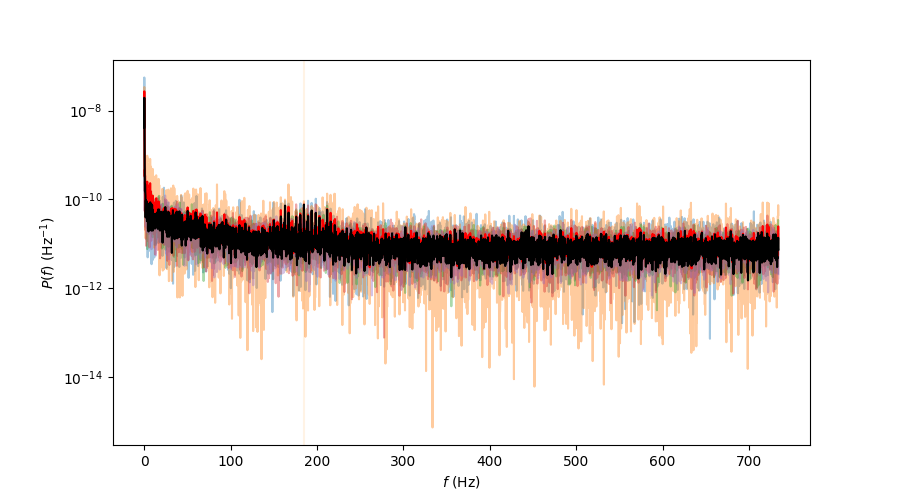

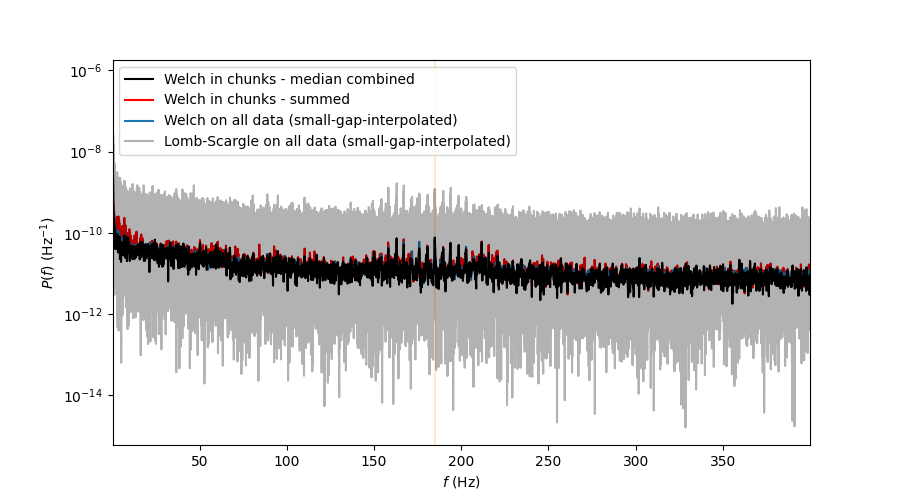

In [45]:
# main toggles 
small_gap_size = 20 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.1 # days

# step number one: identify big and small gaps
gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time_kepler, small_gap_size)

# step number two: interpolate the small gaps
times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time_kepler, flux_kepler, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)

min_welch_chunk = 9 # days  
segment_size = 8 # days

# determine the chunks that we want to use and their sizes - the size of the chunks will help inform the segment size for Welch
chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False)

# now, run Welch on the chunks of data
_, _ = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_kepler, extra_info = True, plot_chunks = False, plot_results = True, plot_welch_comparison = True, known_frequencies = [184.858], plot_log = [False, False])



# Same target with TESS

In [62]:
# download a kepler lighkurve for a known solar-like oscillator
# NOTE: 1 cycle per day is 11.57 microhertz

lc_TESS = lk.search_lightcurve('TIC 48450369', author = 'SPOC').download_all().stitch()

time_TESS = lc_TESS.time.value
flux_TESS = lc_TESS.sap_flux.value

finite = np.isfinite(flux_TESS) * np.isfinite(time_TESS)

time_TESS = time_TESS[finite]
flux_TESS = flux_TESS[finite]

# get the frequency grid
frequency_xlim = [0., 400] # these units are in cycles per day
fgrid_TESS = get_fgrid(time_TESS, 1., frequency_xlim)


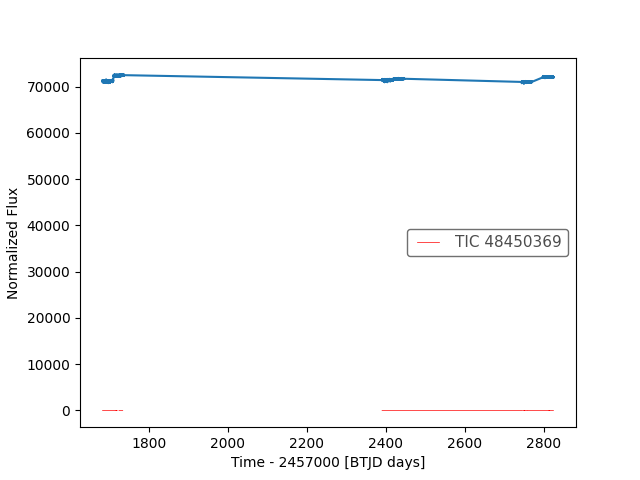

In [63]:
fig, ax = plt.subplots()

lc_TESS.plot(ax = ax, color = 'red')
plt.plot(time_TESS, flux_TESS)

In [64]:
# main toggles 
small_gap_size = 20 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.1 # days

# step number one: identify big and small gaps
gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time_TESS, small_gap_size)

# step number two: interpolate the small gaps
times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time_TESS, flux_TESS, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)


- - - - - 
number of big gaps: 11
number of small gaps: 367
- - - - - 



367it [00:08, 44.94it/s]


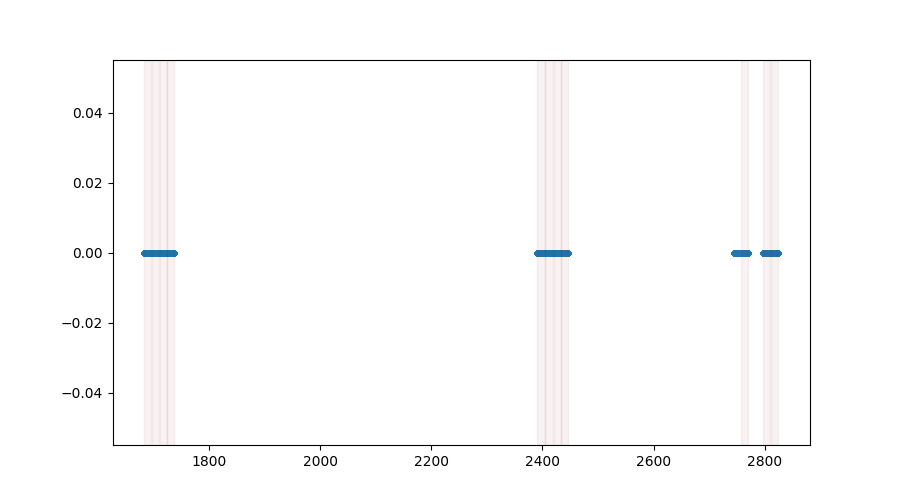


- - - - - 
number of discarded chunks: 1
number of used chunks: 11
- - - - - 


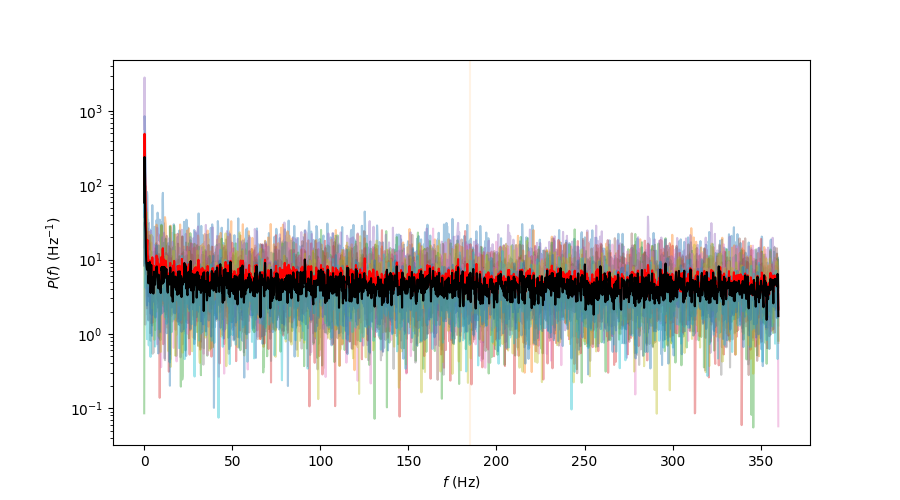

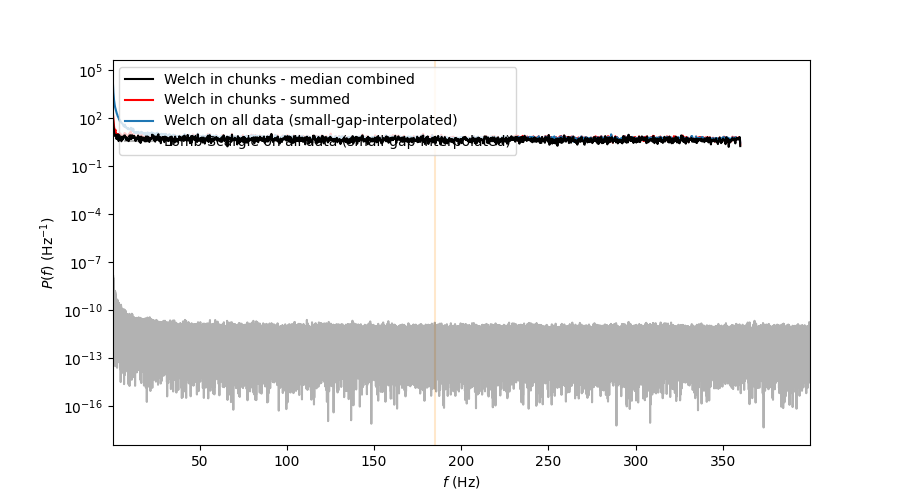

In [69]:

min_welch_chunk = 12 # days  
segment_size = 5 # days

# determine the chunks that we want to use and their sizes - the size of the chunks will help inform the segment size for Welch
chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = True, extra_info = False)

# now, run Welch on the chunks of data
_, _ = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_TESS, extra_info = True, plot_chunks = True, plot_results = True, plot_welch_comparison = True, known_frequencies = [184.858], plot_log = [False, False])
